In [82]:
import textwrap
import numpy as np

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

import calendar

from statsmodels.tsa.seasonal import seasonal_decompose

In [83]:
import warnings
warnings.filterwarnings('ignore')

In [84]:
# Set global seaborn theme with black background
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='dark',
    font='DejaVu Sans',
    rc={
        'axes.facecolor': 'black',        # plot background
        'figure.facecolor': 'black',      # figure background
        'grid.color': '#1A1A1A',        # dark deep gray grid lines
        'axes.edgecolor': 'white',        # axis lines color (we'll make top/right invisible)
        'xtick.color': 'white',
        'ytick.color': 'white',
        'text.color': 'white'
    },
    color_codes=True
)

def custom_theme(ax, title, xlabel, ylabel='Frequency'):
    # Set title and labels
    ax.set_title(title, fontsize=18, fontweight='bold', color='white')
    ax.set_xlabel(xlabel, fontsize=14, fontweight='bold', color='white')
    ax.set_ylabel(ylabel, fontsize=14, fontweight='bold', color='white')
    ax.tick_params(axis='both', which='major', labelsize=12, colors='white')

    # Hide top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # Keep left and bottom spines subtle
    ax.spines['left'].set_color('#333333')
    ax.spines['bottom'].set_color('#333333')

# Define a color for each property type
colors = {
    'building': '#3E64FF',
    'villa': '#FF6B6B',
    'unit': '#44CFCB',
    'land': '#F4A261'
}

type_order = ['unit', 'villa', 'building', 'land']

In [90]:
df = pd.read_csv('./data/raw/transactions.csv')
units = df[df['property_type_en'] == 'unit'].reset_index(drop=True)

areas = gpd.read_file('./data/processed/transaction_land_areas.geojson')

### Basic Overview

In [86]:
df = units.copy()

#### Usage Type Distribution

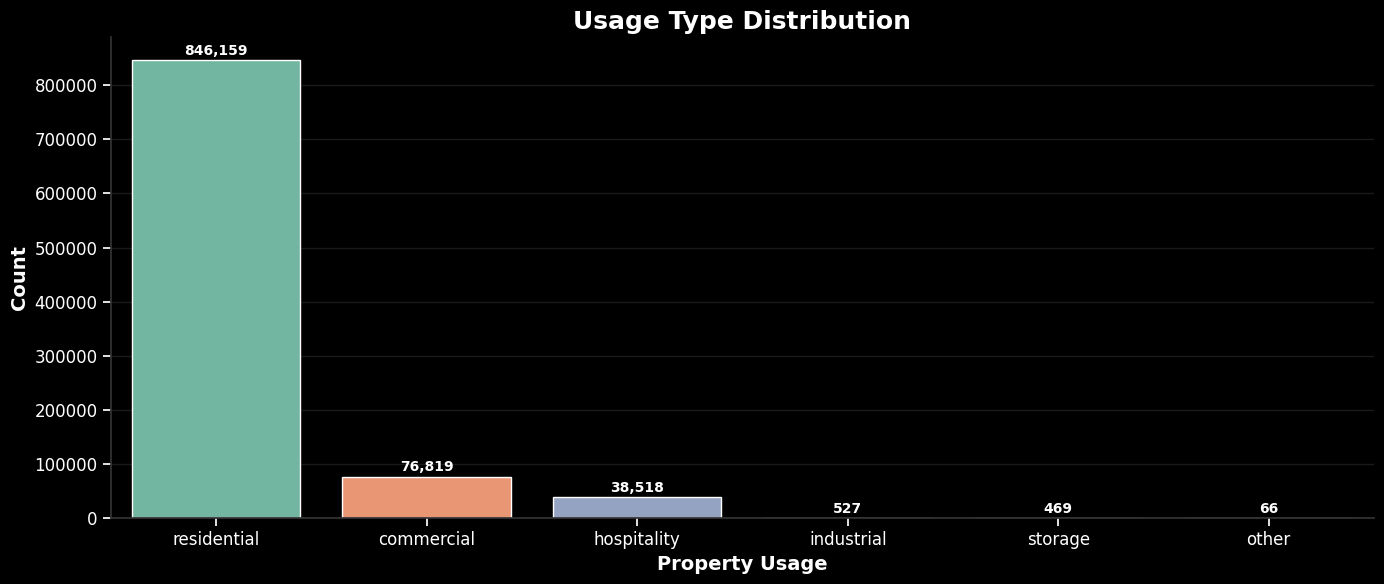

In [22]:
plt.figure(figsize=(14, 6))
palette = sns.color_palette("Set2")

# Get the order of bars from value_counts
usage_order = df['property_usage'].value_counts().index

# Wrap labels according to the order
wrapped_labels = [textwrap.fill(label, 14) for label in usage_order]

ax = sns.countplot(
    x='property_usage',
    data=df,
    palette=palette,
    order=usage_order
)

# Apply your custom theme
custom_theme(
    ax=ax,
    title='Usage Type Distribution',
    xlabel='Property Usage',
    ylabel='Count'
)

# Add integer counts on bars
for p in ax.patches:
    height = int(p.get_height())
    ax.text(
        p.get_x() + p.get_width() / 2,   
        height + df['property_usage'].value_counts().max() * 0.005,
        f'{height:,}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='white',
        fontweight='bold'
    )

# Apply wrapped labels in correct order
plt.xticks(
    ticks=range(len(wrapped_labels)),
    labels=wrapped_labels,
    rotation=0,
    ha='center'
)

plt.tight_layout()
plt.show()

#### Transaction Type Distribution

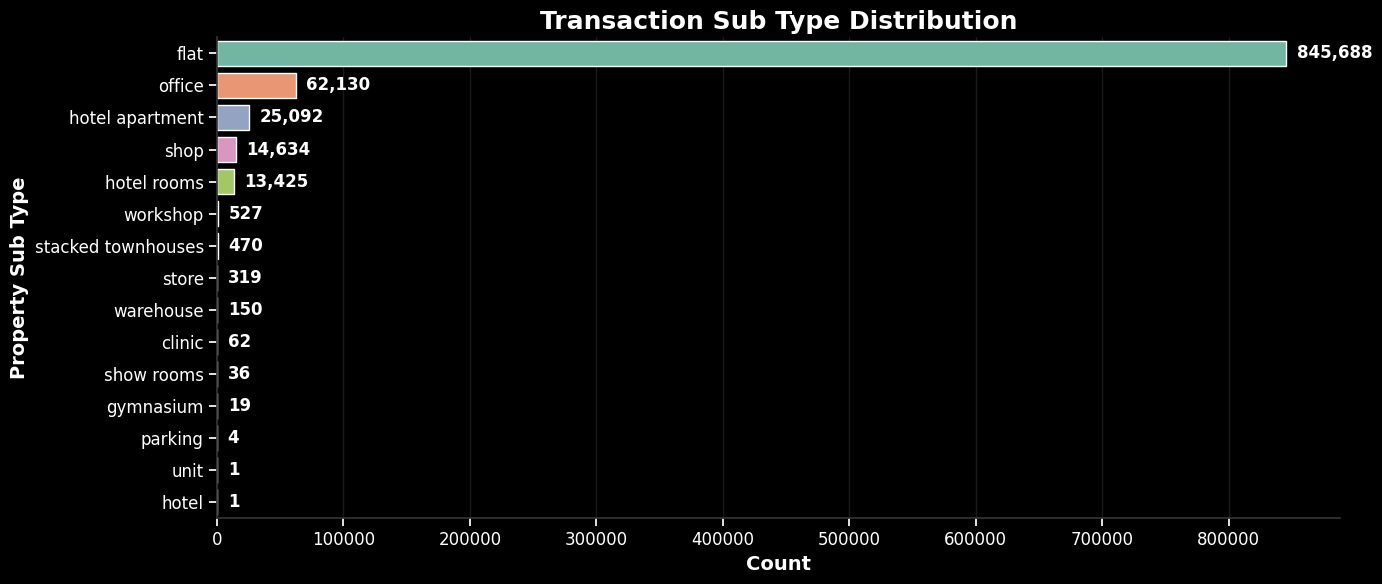

In [24]:
plt.figure(figsize=(14, 6))

palette = sns.color_palette("Set2")

ax = sns.countplot(
    y='property_sub_type',
    data=df,
    palette=palette,
    order=df['property_sub_type'].value_counts().index
)

custom_theme(
    ax=ax,
    title='Transaction Sub Type Distribution',
    xlabel='Count',
    ylabel='Property Sub Type'
)

# Annotate counts on bars
value_counts = df['property_sub_type'].value_counts()
for i, (subtype, count) in enumerate(value_counts.items()):
    ax.text(
        count + (value_counts.max() * 0.01),
        i,
        f'{int(count):,}',
        va='center',
        ha='left',
        fontsize=12,
        fontweight='semibold',
        color='white'
    )

plt.tight_layout()
plt.show()

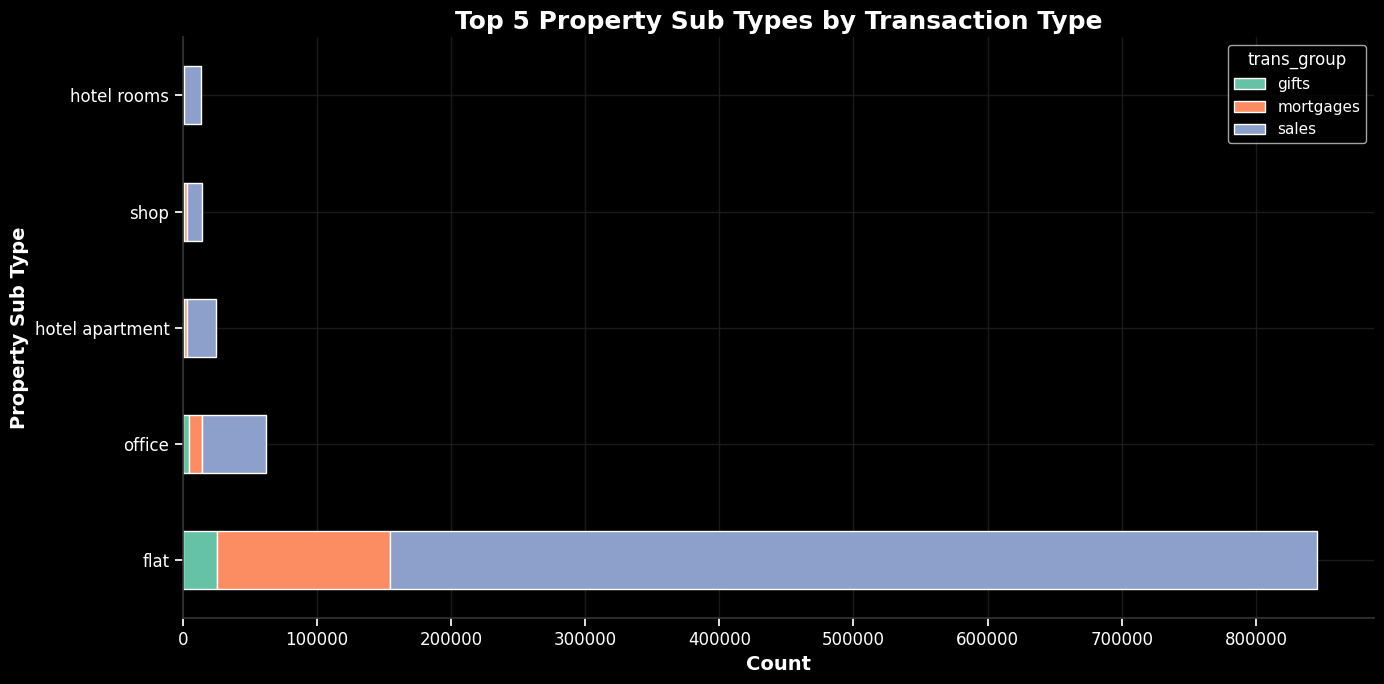

In [25]:
top5_subtypes = df['property_sub_type'].value_counts().head(5).index
top5_df = df[df['property_sub_type'].isin(top5_subtypes)]

stacked_data = top5_df.groupby(['property_sub_type', 'trans_group']).size().unstack(fill_value=0)
stacked_data = stacked_data.loc[stacked_data.sum(axis=1).sort_values(ascending=False).index]

ax = stacked_data.plot(
    kind='barh',
    stacked=True,
    figsize=(14, 7),
    color=sns.color_palette("Set2", n_colors=stacked_data.shape[1])
)

custom_theme(
    ax=ax,
    title='Top 5 Property Sub Types by Transaction Type',
    xlabel='Count',
    ylabel='Property Sub Type'
)

plt.tight_layout()
plt.show()

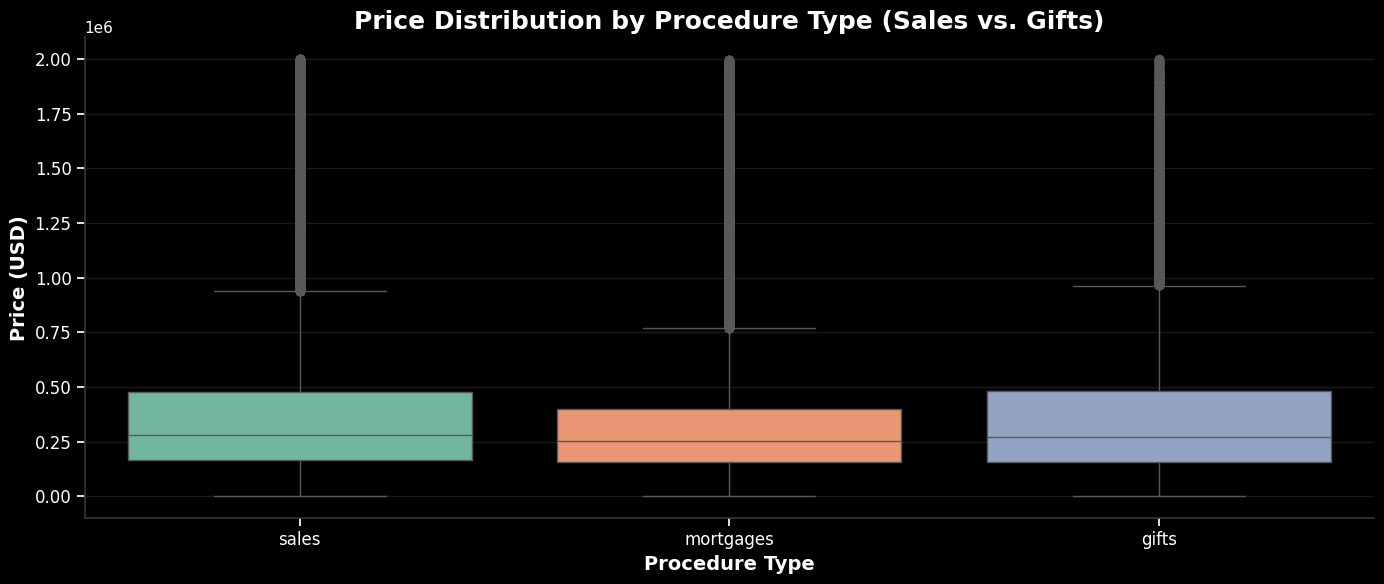

In [10]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='trans_group', y='actual_worth_usd', data=df, palette='Set2')

# Apply custom theme
custom_theme(plt.gca(), title='Price Distribution by Procedure Type (Sales vs. Gifts)', xlabel='Procedure Type', ylabel='Price (USD)')

# Display the plot
plt.tight_layout()
plt.show()

#### Transactions by Number of Rooms

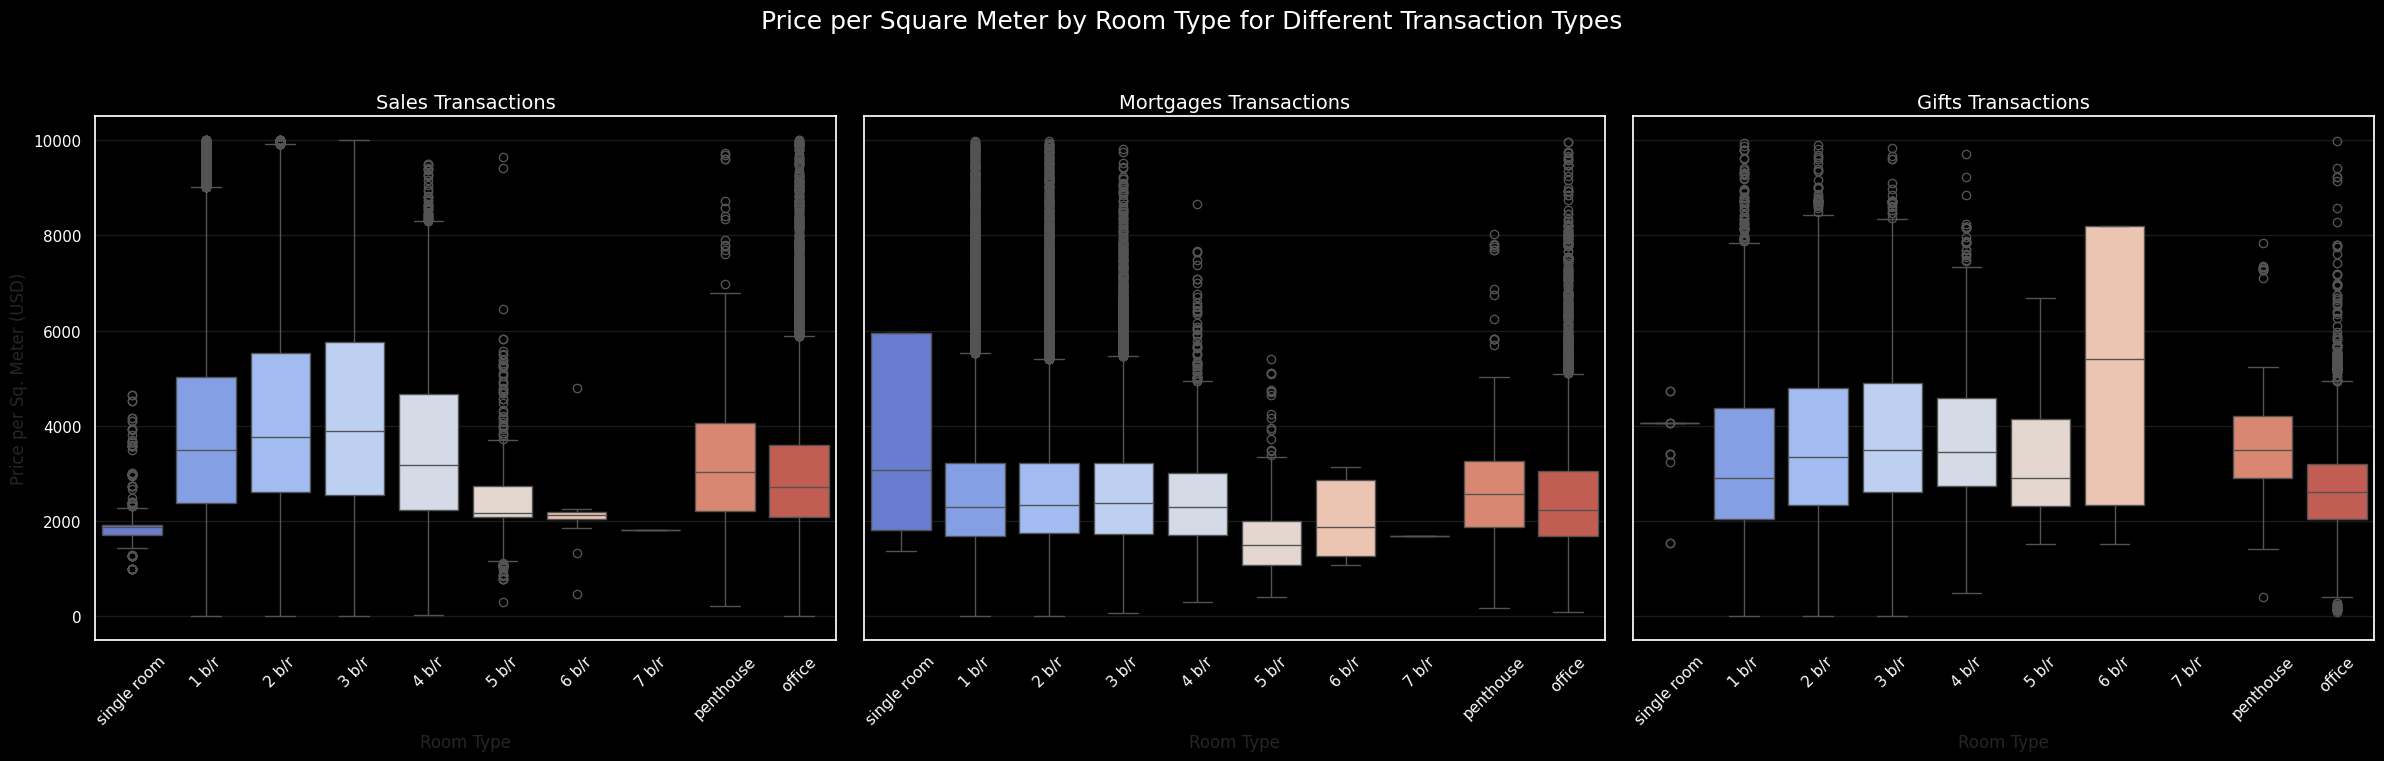

In [27]:
# Set the room order again to ensure consistency
room_order = ['single room', '1 b/r', '2 b/r', '3 b/r', '4 b/r', '5 b/r', '6 b/r', '7 b/r', 'penthouse', 'office']
df['rooms'] = pd.Categorical(df['rooms'].str.lower(), categories=room_order, ordered=True)

# Filter dataset for usable entries
df_cleaned = df.dropna(subset=['meter_sale_price_usd', 'rooms', 'trans_group'])
df_cleaned['rooms'] = df_cleaned['rooms'].str.lower().astype(str)
df_cleaned = df_cleaned[df_cleaned['rooms'].isin(room_order)]
df_cleaned['meter_sale_price_usd'] = pd.to_numeric(df_cleaned['meter_sale_price_usd'], errors='coerce')

# Limit price for clearer visualization
price_cap = 10000
df_cleaned = df_cleaned[df_cleaned['meter_sale_price_usd'] <= price_cap]

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

# Plot for each transaction group
for ax, group in zip(axes, df_cleaned['trans_group'].unique()):
    subset = df_cleaned[df_cleaned['trans_group'] == group]
    sns.boxplot(data=subset, x='rooms', y='meter_sale_price_usd', ax=ax, palette='coolwarm', order=room_order)
    ax.set_title(f"{group.capitalize()} Transactions", fontsize=14)
    ax.set_xlabel("Room Type")
    ax.set_ylabel("Price per Sq. Meter (USD)")
    ax.tick_params(axis='x', rotation=45)

plt.suptitle("Price per Square Meter by Room Type for Different Transaction Types", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

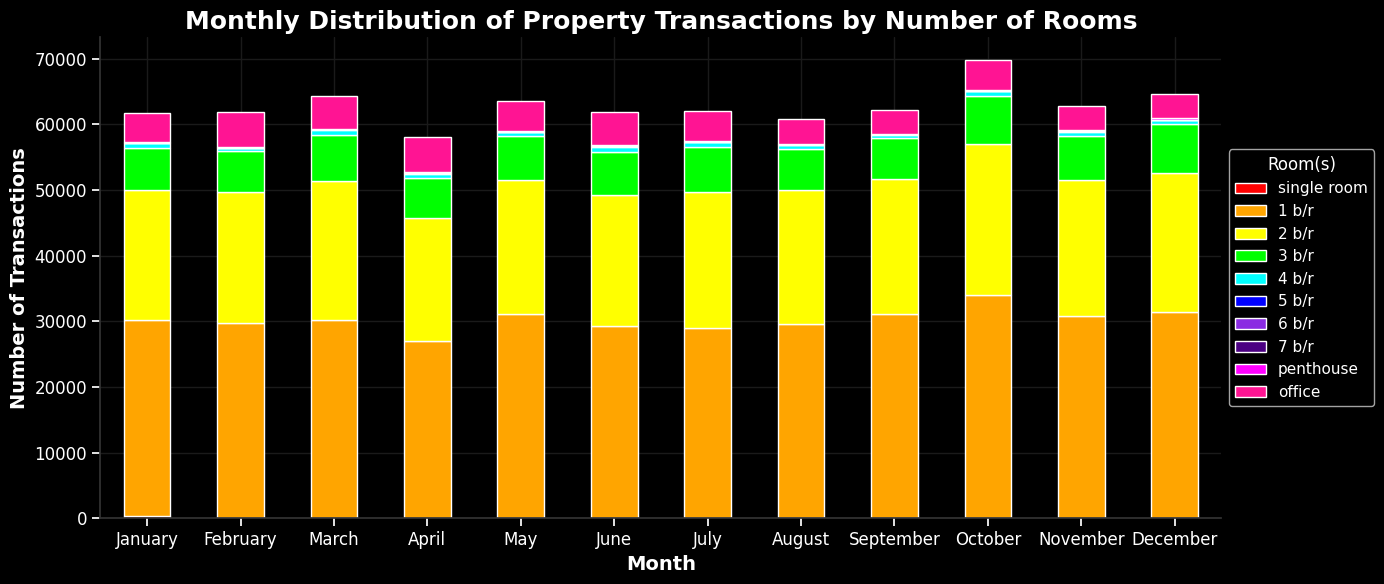

In [30]:
df['month'] = pd.to_datetime(df['instance_date']).dt.month

room_month_counts = df.groupby(['rooms', 'month']).size().reset_index(name='counts')
pivot_df = room_month_counts.pivot(index='month', columns='rooms', values='counts').fillna(0)

colors = ['#FF0000', '#FFA500', '#FFFF00', '#00FF00', '#00FFFF', 
          '#0000FF', '#8A2BE2', '#4B0082', '#FF00FF', '#FF1493']

fig, ax = plt.subplots(figsize=(14, 6))
pivot_df.plot(kind='bar', stacked=True, color=colors, ax=ax)

custom_theme(
    ax=ax,
    title='Monthly Distribution of Property Transactions by Number of Rooms',
    xlabel='Month',
    ylabel='Number of Transactions'
)

ax.set_xticklabels([calendar.month_name[int(m)] for m in pivot_df.index], rotation=0, ha='center')
ax.legend(title='Room(s)', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

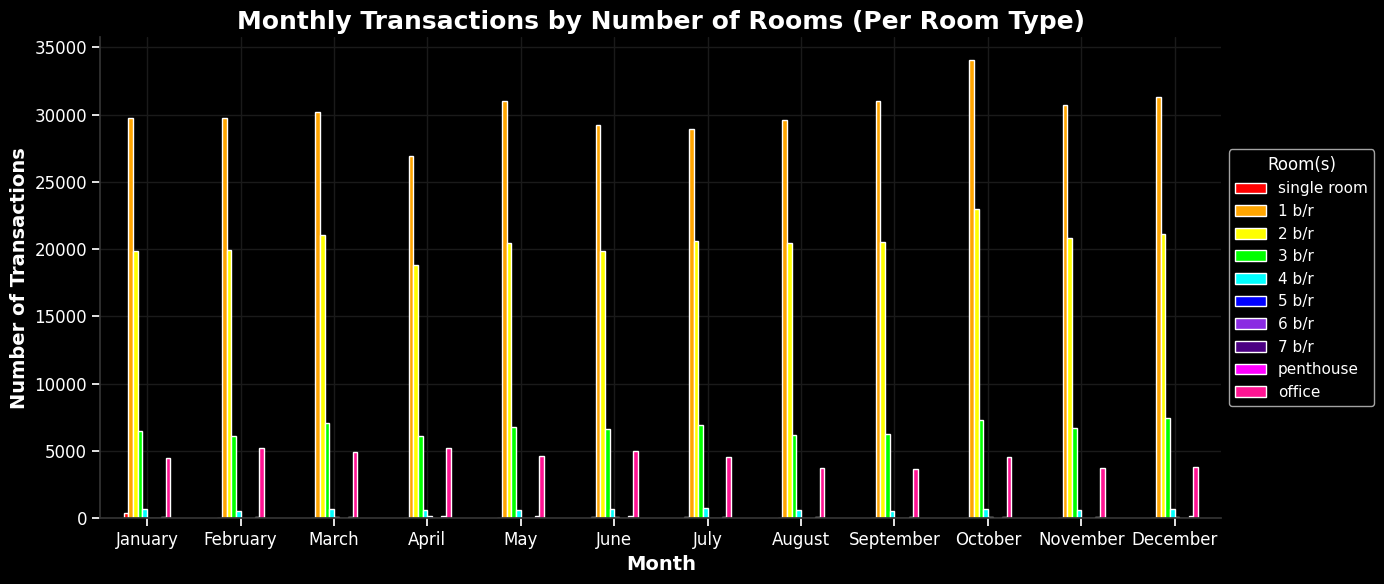

In [31]:
# Plot non-stacked bar chart
fig, ax = plt.subplots(figsize=(14, 6))
pivot_df.plot(kind='bar', stacked=False, color=colors, ax=ax)

# Apply custom theme
custom_theme(
    ax=ax,
    title='Monthly Transactions by Number of Rooms (Per Room Type)',
    xlabel='Month',
    ylabel='Number of Transactions'
)

# Set x-axis ticks to month names
ax.set_xticklabels([calendar.month_name[int(m)] for m in pivot_df.index], rotation=0, ha='center')

# Place legend outside for readability
ax.legend(title='Room(s)', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

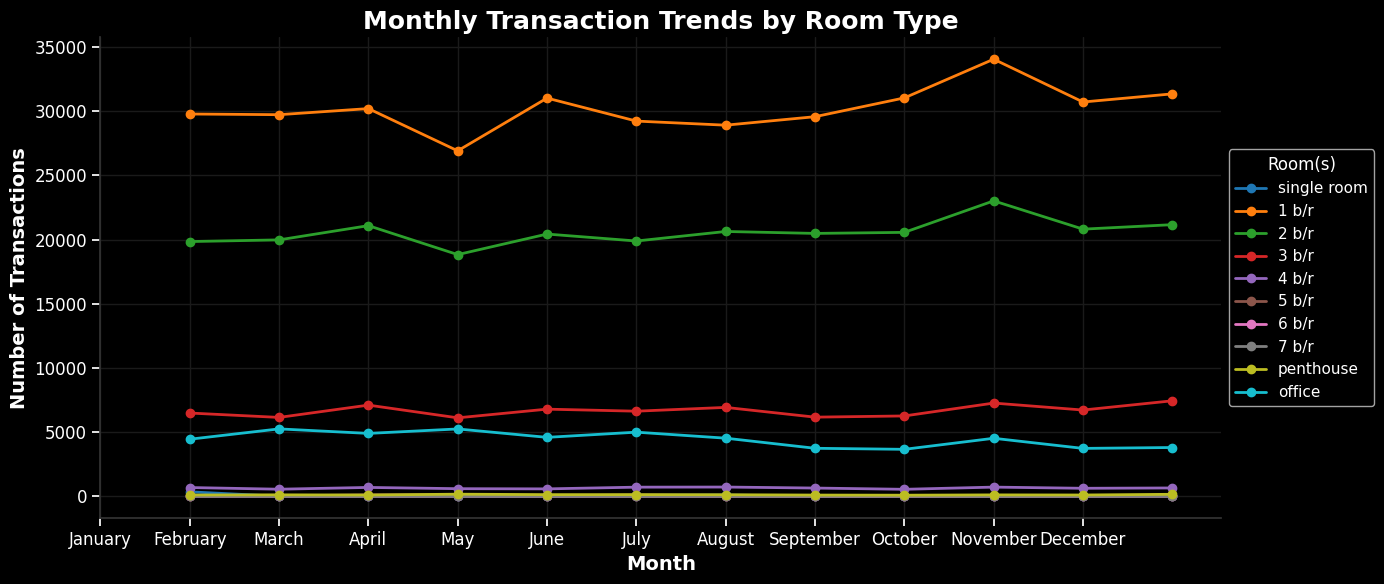

In [32]:
fig, ax = plt.subplots(figsize=(14, 6))

palette = sns.color_palette("tab10", n_colors=pivot_df.shape[1])
for i, col in enumerate(pivot_df.columns):
    ax.plot(
        pivot_df.index,
        pivot_df[col],
        marker='o',
        label=col,
        color=palette[i],
        linewidth=2
    )

custom_theme(
    ax=ax,
    title='Monthly Transaction Trends by Room Type',
    xlabel='Month',
    ylabel='Number of Transactions'
)

ax.set_xticks(range(len(pivot_df.index)))
ax.set_xticklabels([calendar.month_name[int(m)] for m in pivot_df.index], rotation=0, ha='center')

ax.legend(title='Room(s)', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

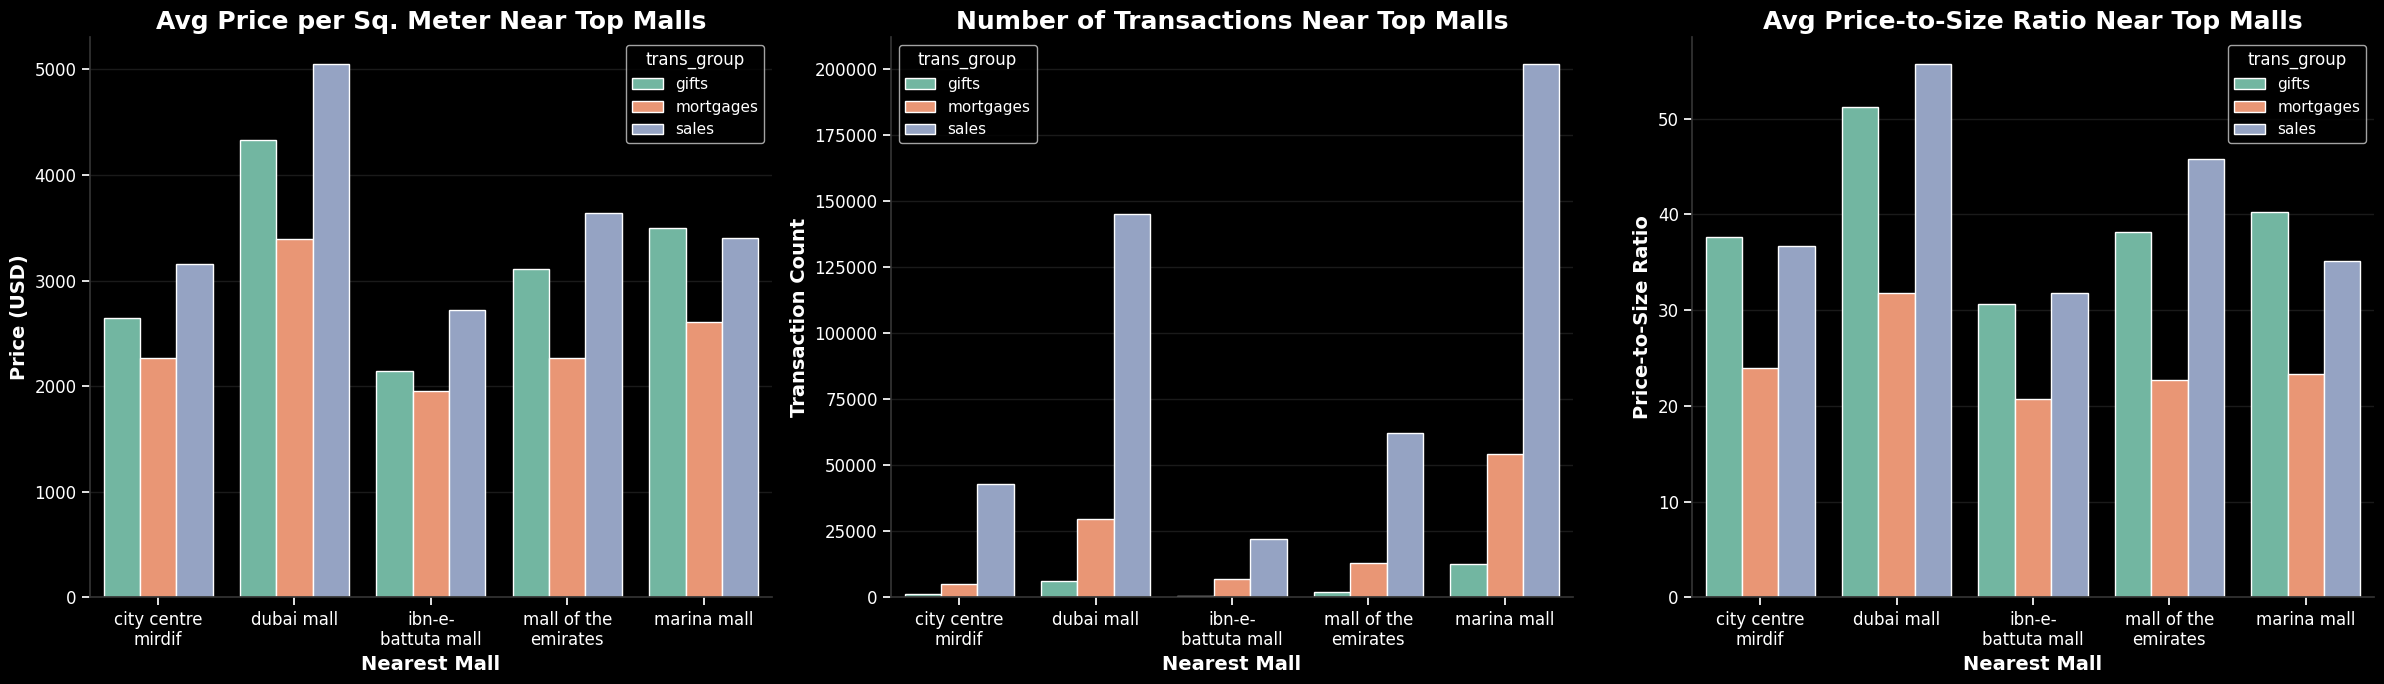

In [47]:
def wrap_labels(ax, width=12):
    """Wrap only the label text, not the tick object."""
    new_labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        wrapped = textwrap.fill(text, width)
        new_labels.append(wrapped)
    ax.set_xticklabels(new_labels)


fig, axes = plt.subplots(1, 3, figsize=(24, 7))
plt.subplots_adjust(wspace=0.3)

# Focus on top malls by frequency
top_malls = df_cleaned['nearest_mall'].value_counts().nlargest(10).index
mall_data = df_cleaned[df_cleaned['nearest_mall'].isin(top_malls)]

# ----------------------------------------------------------
# 1. Avg Price per Sq Meter
# ----------------------------------------------------------
mall_price = (
    mall_data.groupby(['nearest_mall', 'trans_group'])['meter_sale_price_usd']
    .mean().reset_index()
)

ax0 = axes[0]
sns.barplot(
    data=mall_price,
    x='nearest_mall',
    y='meter_sale_price_usd',
    hue='trans_group',
    ax=ax0,
    palette='Set2'
)

wrap_labels(ax0, 12)

custom_theme(
    ax=ax0,
    title="Avg Price per Sq. Meter Near Top Malls",
    xlabel="Nearest Mall",
    ylabel="Price (USD)"
)

ax0.tick_params(axis='x', rotation=0)

# ----------------------------------------------------------
# 2. Count of Transactions
# ----------------------------------------------------------
mall_count = (
    mall_data.groupby(['nearest_mall', 'trans_group'])['transaction_id']
    .count().reset_index()
    .rename(columns={'transaction_id': 'count'})
)

ax1 = axes[1]
sns.barplot(
    data=mall_count,
    x='nearest_mall',
    y='count',
    hue='trans_group',
    ax=ax1,
    palette='Set2'
)

wrap_labels(ax1, 12)

custom_theme(
    ax=ax1,
    title="Number of Transactions Near Top Malls",
    xlabel="Nearest Mall",
    ylabel="Transaction Count"
)

ax1.tick_params(axis='x', rotation=0)

# ----------------------------------------------------------
# 3. Avg Price-to-Size Ratio
# ----------------------------------------------------------
mall_ratio = (
    mall_data.groupby(['nearest_mall', 'trans_group'])['price_to_size_ratio']
    .mean().reset_index()
)

ax2 = axes[2]
sns.barplot(
    data=mall_ratio,
    x='nearest_mall',
    y='price_to_size_ratio',
    hue='trans_group',
    ax=ax2,
    palette='Set2'
)

wrap_labels(ax2, 12)

custom_theme(
    ax=ax2,
    title="Avg Price-to-Size Ratio Near Top Malls",
    xlabel="Nearest Mall",
    ylabel="Price-to-Size Ratio"
)

ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


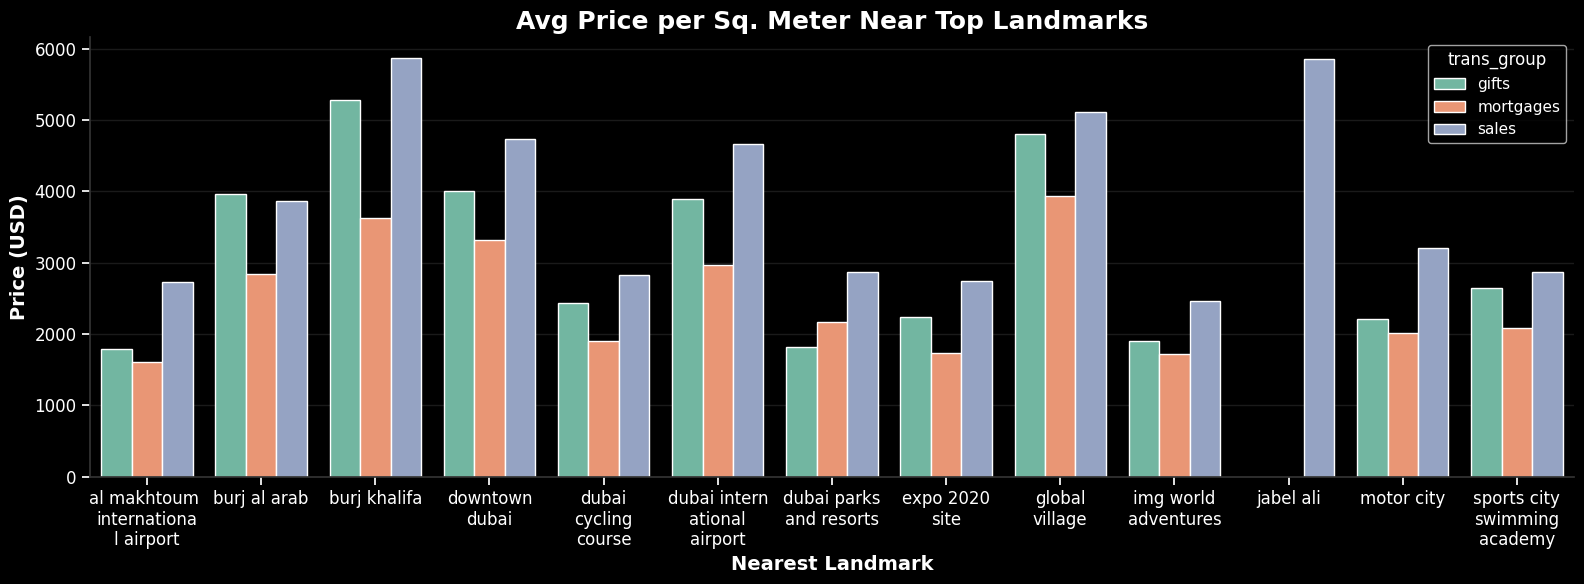

In [44]:
# Focus on top landmarks by frequency
top_landmarks = df_cleaned['nearest_landmark'].value_counts().nlargest(14).index
landmark_data = df_cleaned[df_cleaned['nearest_landmark'].isin(top_landmarks)]

# --- Avg Price per Sq Meter ---
landmark_price = (
    landmark_data.groupby(['nearest_landmark', 'trans_group'])['meter_sale_price_usd']
    .mean()
    .reset_index()
)

plt.figure(figsize=(16, 6))
ax = sns.barplot(
    data=landmark_price,
    x='nearest_landmark',
    y='meter_sale_price_usd',
    hue='trans_group',
    palette='Set2'
)

# Wrap labels cleanly
wrap_labels(ax, width=12)

# Apply custom theme
custom_theme(
    ax=ax,
    title="Avg Price per Sq. Meter Near Top Landmarks",
    xlabel="Nearest Landmark",
    ylabel="Price (USD)"
)

ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

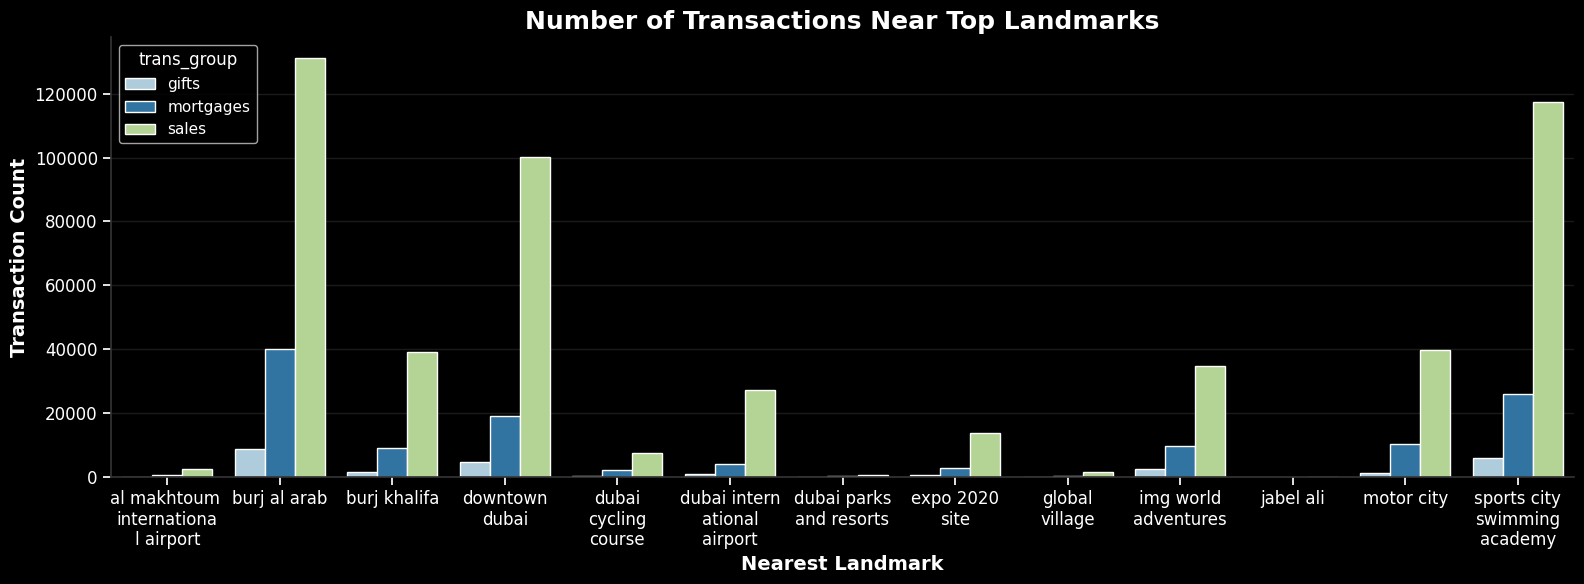

In [50]:
top_landmarks = df_cleaned['nearest_landmark'].value_counts().nlargest(14).index
landmark_data = df_cleaned[df_cleaned['nearest_landmark'].isin(top_landmarks)]

# --- Count of Transactions ---
landmark_count = (
    landmark_data.groupby(['nearest_landmark', 'trans_group'])['transaction_id']
    .count()
    .reset_index()
    .rename(columns={'transaction_id': 'count'})
)

plt.figure(figsize=(16, 6))
ax = sns.barplot(
    data=landmark_count,
    x='nearest_landmark',
    y='count',
    hue='trans_group',
    palette='Paired'
)

# Wrap labels correctly
wrap_labels(ax, width=12)

# Apply custom theme
custom_theme(
    ax=ax,
    title="Number of Transactions Near Top Landmarks",
    xlabel="Nearest Landmark",
    ylabel="Transaction Count"
)

ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

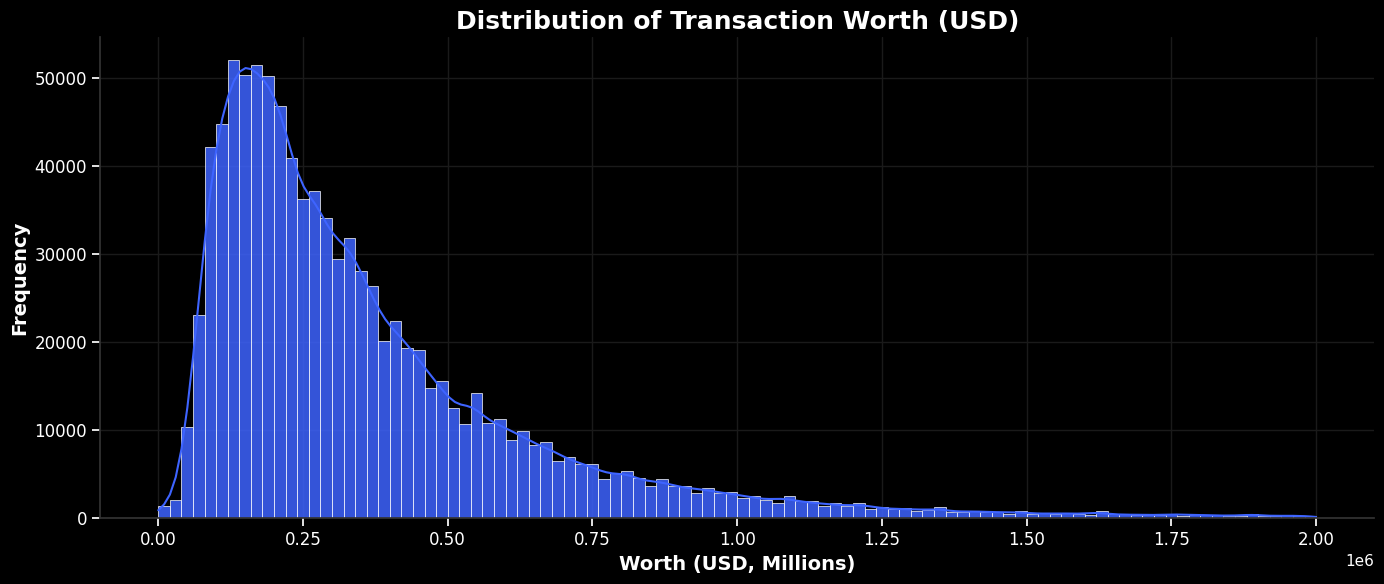

In [54]:
plt.figure(figsize=(14, 6))
ax = sns.histplot(df['actual_worth_usd'], bins=100, kde=True, color='#3E64FF', edgecolor='white', linewidth=0.5, alpha=0.85)

# Custom theme
custom_theme(ax, 'Distribution of Transaction Worth (USD)', 'Worth (USD, Millions)')
plt.tight_layout()
plt.show()

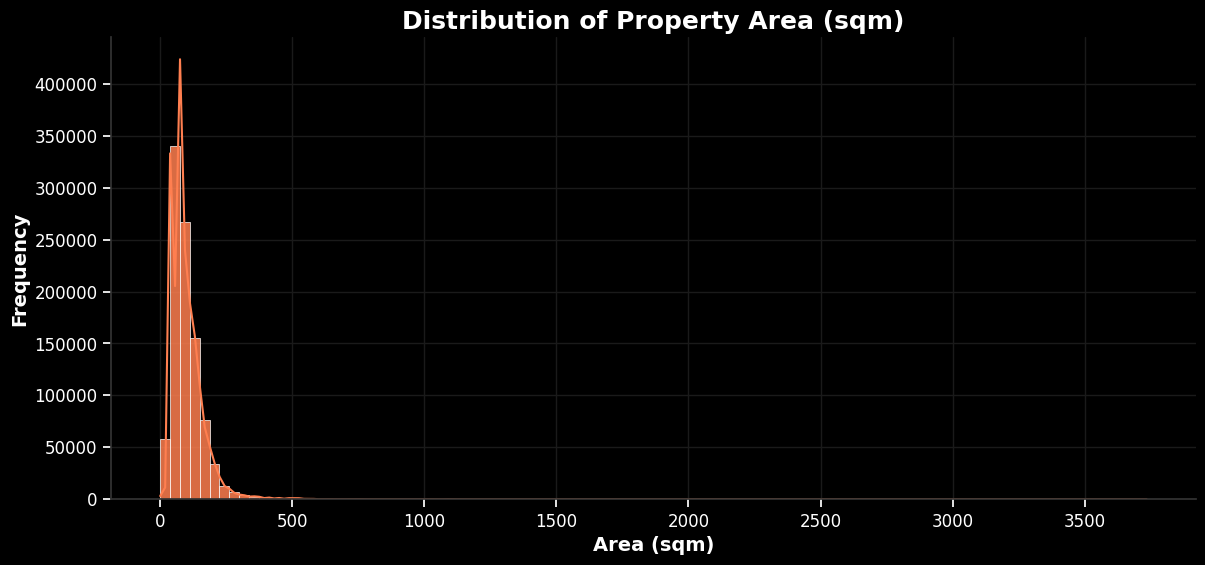

In [55]:
plt.figure(figsize=(14, 6))
ax = sns.histplot(df[df['procedure_area_sqm'] <= 18000]['procedure_area_sqm'], bins=100, kde=True, color='#FF7F50', edgecolor='white', linewidth=0.5, alpha=0.85)

custom_theme(ax, 'Distribution of Property Area (sqm)', 'Area (sqm)')
plt.show()

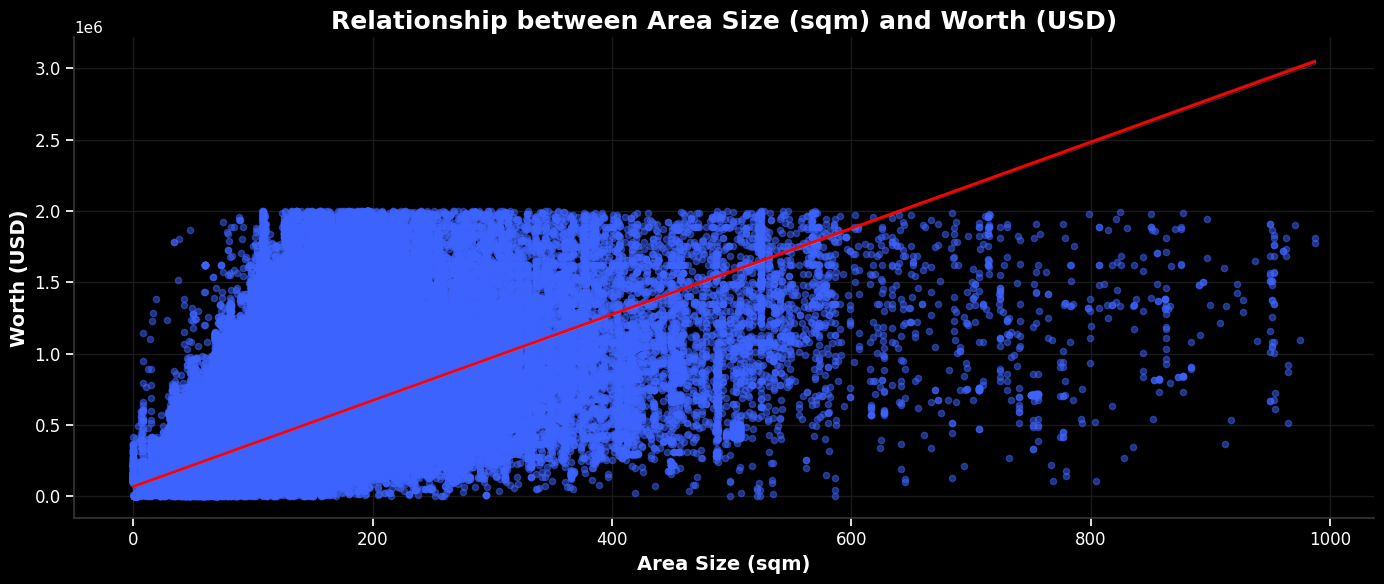

In [ ]:
plt.figure(figsize=(14, 6))
ax = sns.regplot(
    data=df[df['procedure_area_sqm']<=1000],
    x='procedure_area_sqm',
    y='actual_worth_usd',
    scatter_kws={'alpha': 0.5, 's': 20, 'color': '#3E64FF'},
    line_kws={'color': 'red', 'linewidth': 2}
)

# Apply your custom theme
custom_theme(ax, 'Relationship between Area Size (sqm) and Worth (USD)', 'Area Size (sqm)', 'Worth (USD)')

plt.tight_layout()
plt.show()

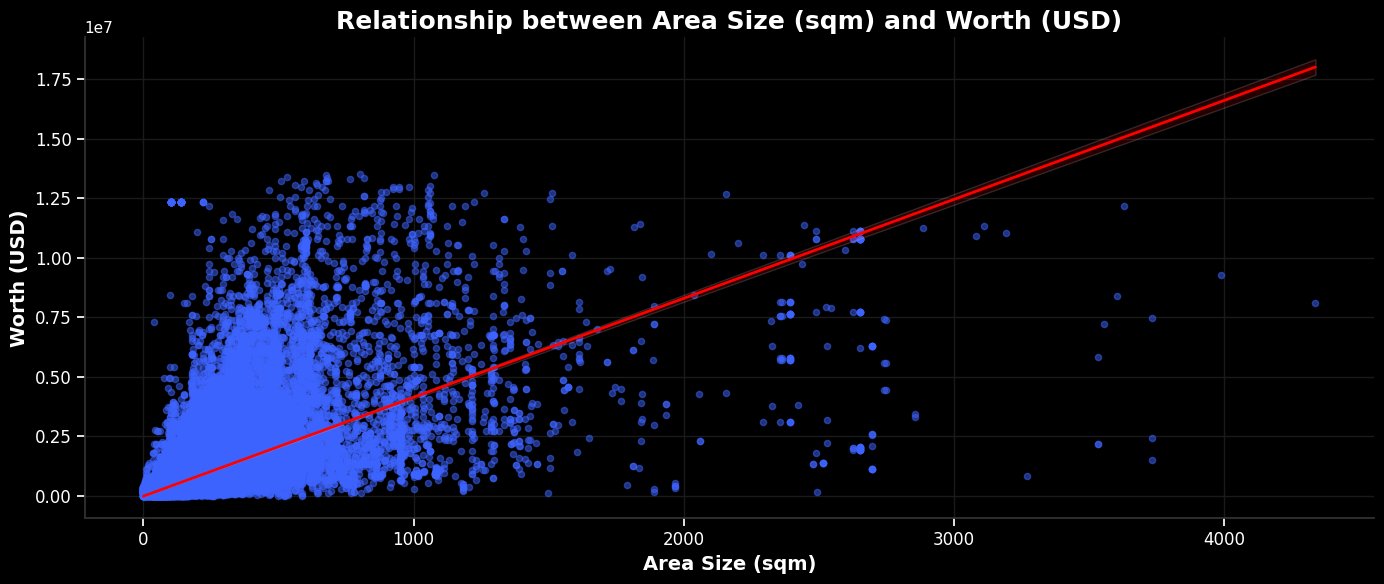

In [ ]:
df['actual_worth'] = df['actual_worth'] * 0.27
plt.figure(figsize=(14, 6))
ax = sns.regplot(
    data=df[(df['property_type_en'] =='Unit') & (df['procedure_area'] <=5000) & (df['actual_worth'] < (50000000 * 0.27))],
    x='procedure_area',
    y='actual_worth',
    scatter_kws={'alpha': 0.5, 's': 20, 'color': '#3E64FF'},
    line_kws={'color': 'red', 'linewidth': 2}
)

# Apply your custom theme
custom_theme(ax, 'Relationship between Area Size (sqm) and Worth (USD)', 'Area Size (sqm)', 'Worth (USD)')

plt.tight_layout()
plt.show()

### Time Series Analysis

In [59]:
df['instance_date'] = pd.to_datetime(df['instance_date'], errors='coerce')

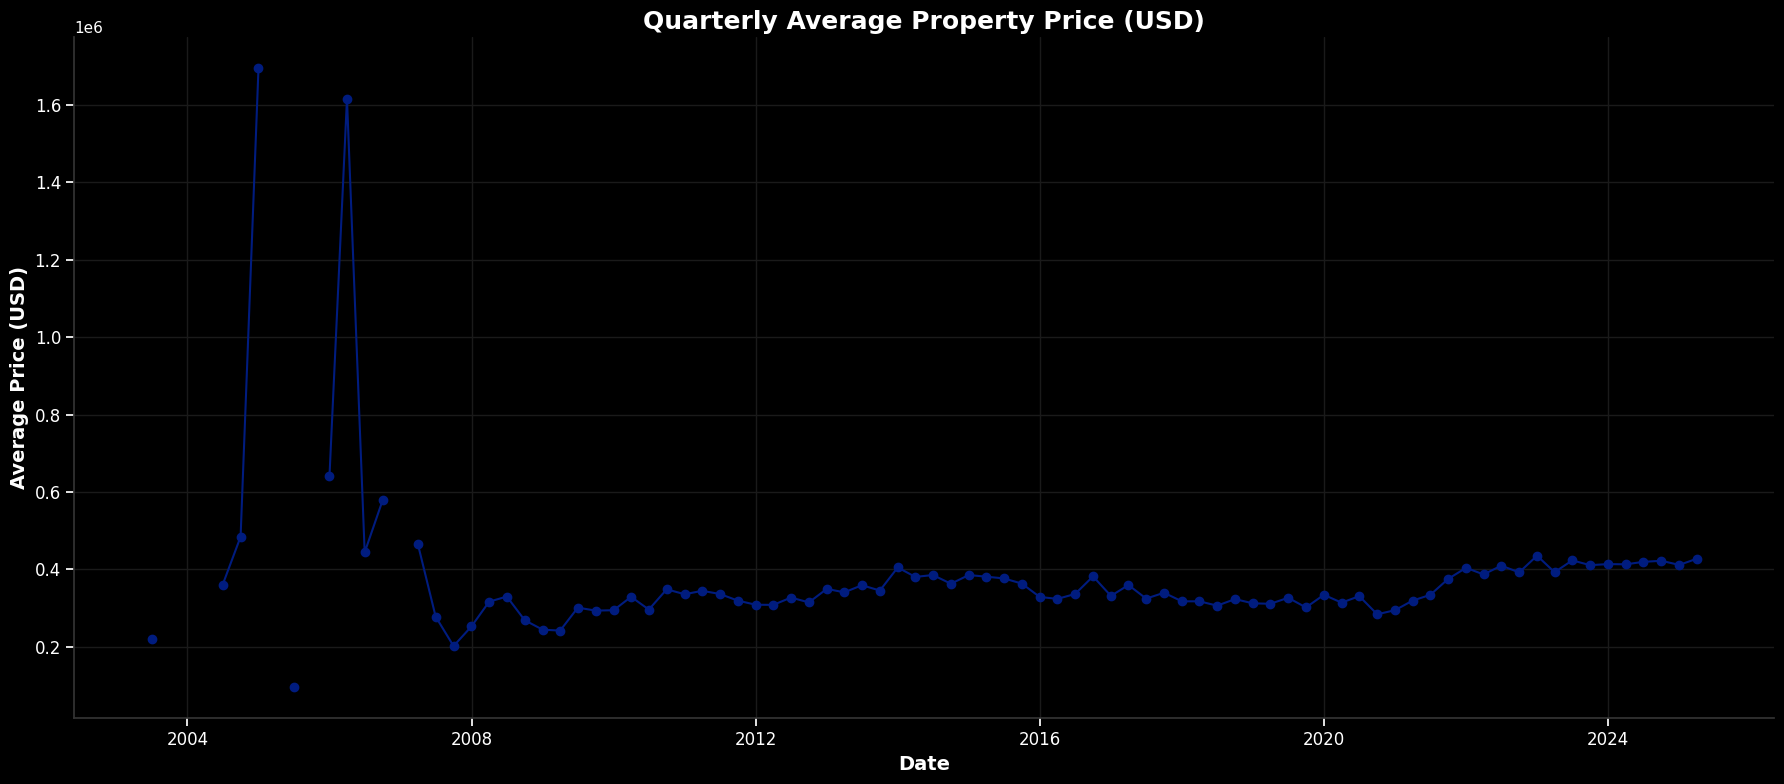

In [60]:
quarterly_prices = df.set_index('instance_date').resample('Q')['actual_worth_usd'].mean()

# Plot
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(quarterly_prices.index, quarterly_prices.values, marker='o')

custom_theme(ax, title='Quarterly Average Property Price (USD)', xlabel='Date', ylabel='Average Price (USD)')

ax.grid(True)
plt.tight_layout()
plt.show()

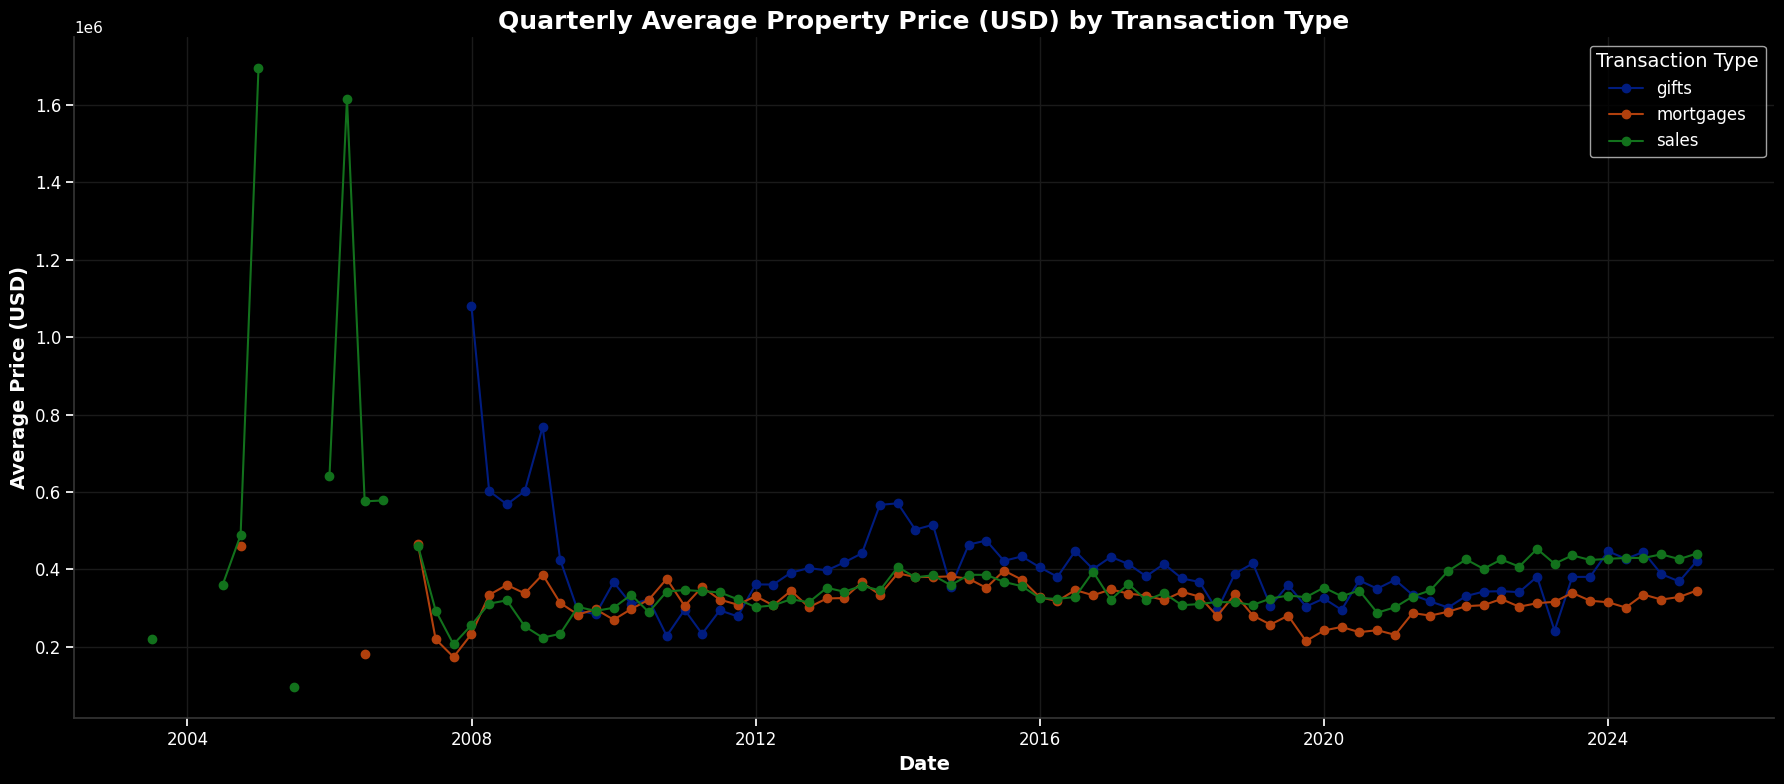

In [61]:
# Group by 'trans_group' and calculate the quarterly average for 'actual_worth_usd'
quarterly_prices_by_type = df.groupby('trans_group').resample('Q', on='instance_date')['actual_worth_usd'].mean().unstack(level=0)

# Plot
fig, ax = plt.subplots(figsize=(18, 8))

# Plot each transaction type on the same graph
for trans_type in quarterly_prices_by_type.columns:
    ax.plot(quarterly_prices_by_type.index, quarterly_prices_by_type[trans_type], marker='o', label=trans_type)

# Apply custom theme for the plot
custom_theme(ax, title='Quarterly Average Property Price (USD) by Transaction Type', xlabel='Date', ylabel='Average Price (USD)')

# Add grid, legend, and adjust layout
ax.grid(True)
ax.legend(title="Transaction Type", fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

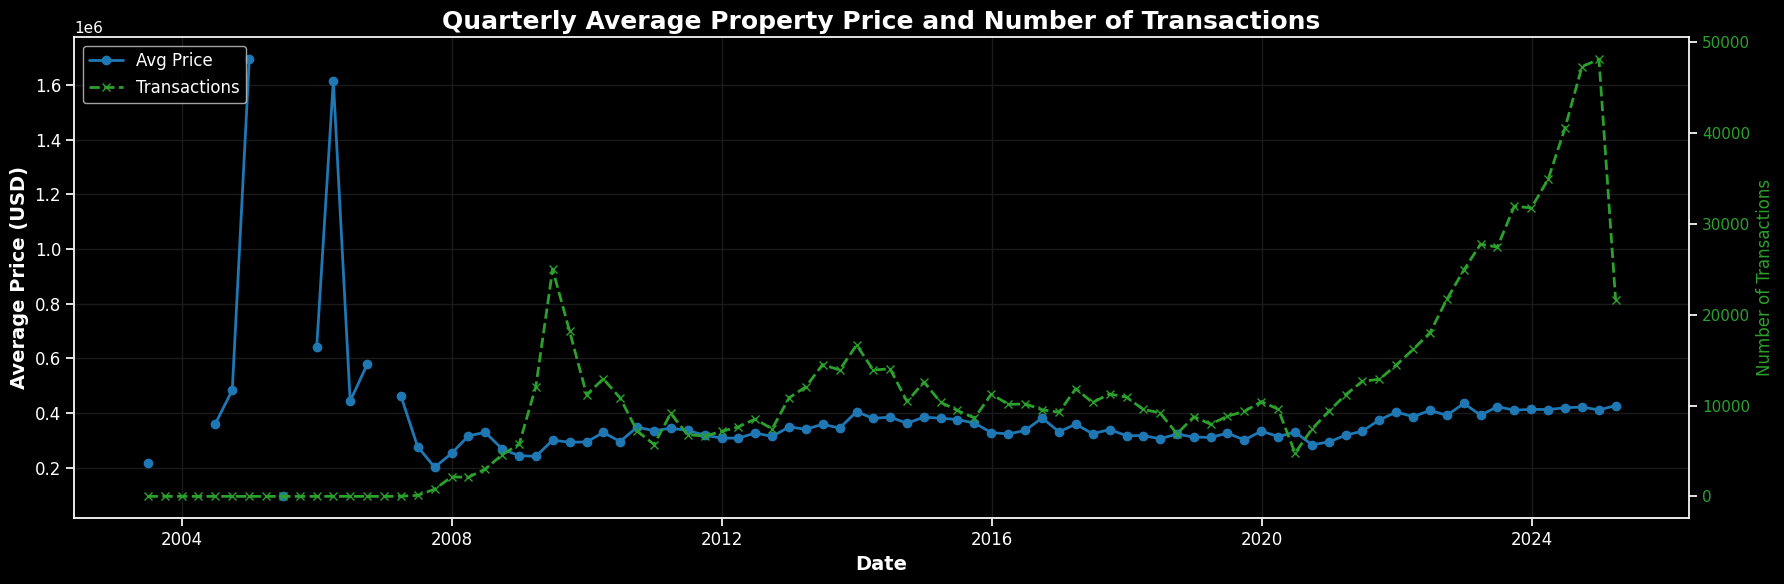

In [63]:
# Resample by quarter
quarterly_prices = df.set_index('instance_date').resample('Q')['actual_worth_usd'].mean()
quarterly_transactions = df.set_index('instance_date').resample('Q').size()

# Plot
fig, ax1 = plt.subplots(figsize=(18, 6))

# First y-axis for average price
color1 = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Price (USD)', color=color1)
ax1.plot(quarterly_prices.index, quarterly_prices.values, color=color1, marker='o', label='Avg Price', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)  # Grid for the first axis

# Apply custom theme to ax1
custom_theme(ax1, title='Quarterly Average Property Price and Number of Transactions', xlabel='Date', ylabel='Average Price (USD)')

# Second y-axis for number of transactions
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('Number of Transactions', color=color2)
ax2.plot(quarterly_transactions.index, quarterly_transactions.values, color=color2, linestyle='--', marker='x', label='Transactions', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)

# Remove grid from ax2 to avoid double grid
ax2.grid(False)

# Apply custom theme to ax2 separately
# custom_theme(ax2, title='', xlabel='Date', ylabel='Number of Transactions')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()

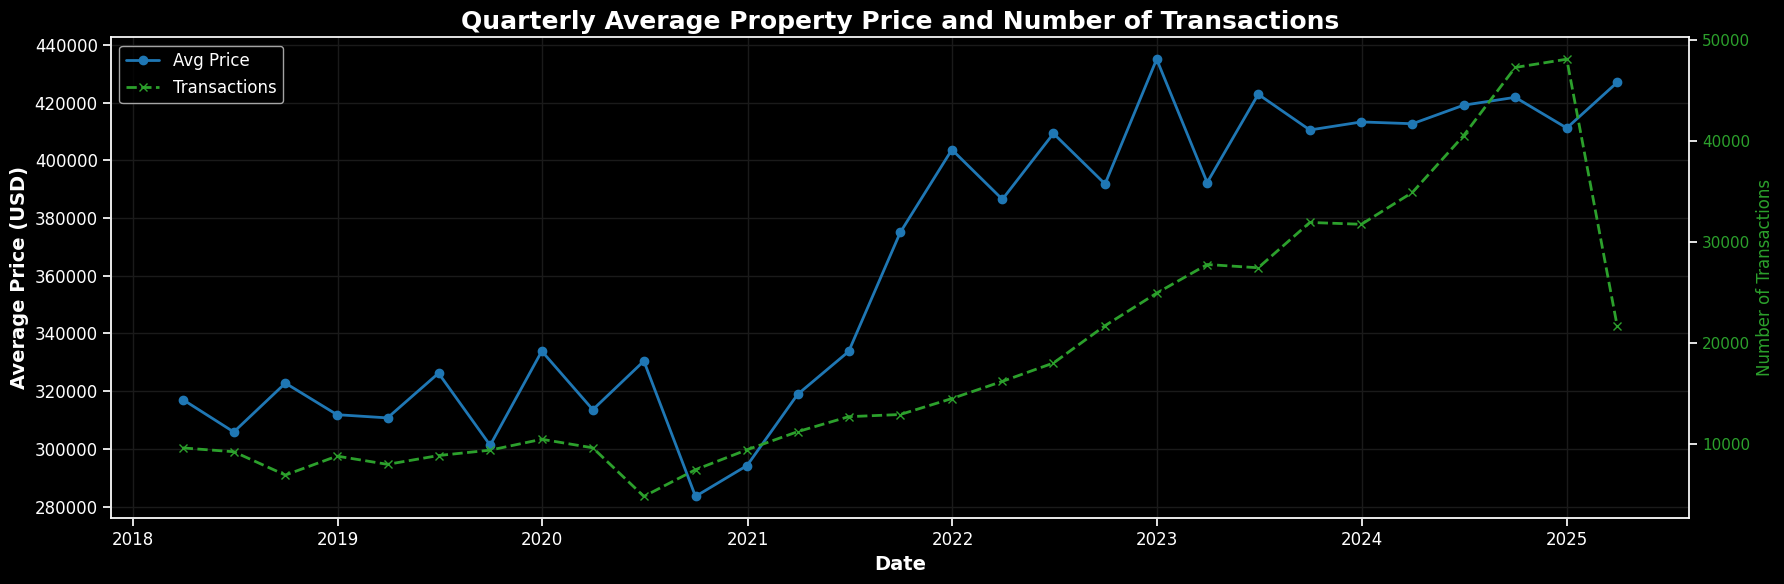

In [65]:
# Resample by quarter
quarterly_prices = df[df['instance_date'].dt.year >= 2018].set_index('instance_date').resample('Q')['actual_worth_usd'].mean()
quarterly_transactions = df[df['instance_date'].dt.year >= 2018].set_index('instance_date').resample('Q').size()

# Plot
fig, ax1 = plt.subplots(figsize=(18, 6))

# First y-axis for average price
color1 = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Price (USD)', color=color1)
ax1.plot(quarterly_prices.index, quarterly_prices.values, color=color1, marker='o', label='Avg Price', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color1)

# Apply custom theme to ax1
custom_theme(ax1, title='Quarterly Average Property Price and Number of Transactions', xlabel='Date', ylabel='Average Price (USD)')

# Second y-axis for number of transactions
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('Number of Transactions', color=color2)
ax2.plot(quarterly_transactions.index, quarterly_transactions.values, color=color2, linestyle='--', marker='x', label='Transactions', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)

# Apply custom theme to ax2 separately
# custom_theme(ax2, title='', xlabel='Date', ylabel='Number of Transactions')

# Remove grid from the second axis to avoid double grid
ax1.grid(True)  # Ensure only the first axis has a grid
ax2.grid(False)  # Ensure only the first axis has a grid

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()

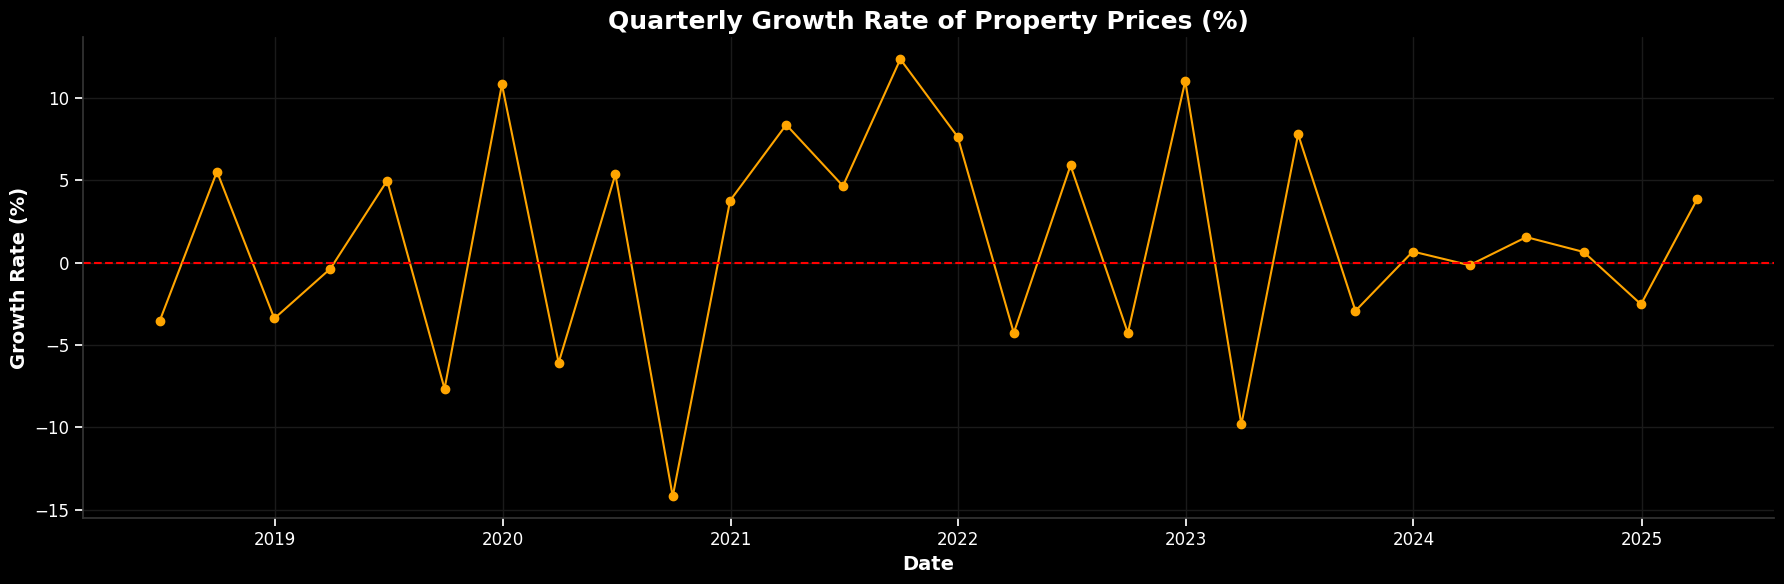

In [67]:
quarterly_growth = quarterly_prices.pct_change() * 100

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(quarterly_growth.index, quarterly_growth.values, marker='o', color='orange')
custom_theme(ax, title='Quarterly Growth Rate of Property Prices (%)', xlabel='Date', ylabel='Growth Rate (%)')
ax.axhline(0, color='red', linestyle='--')
ax.grid(True)
plt.tight_layout()
plt.show()

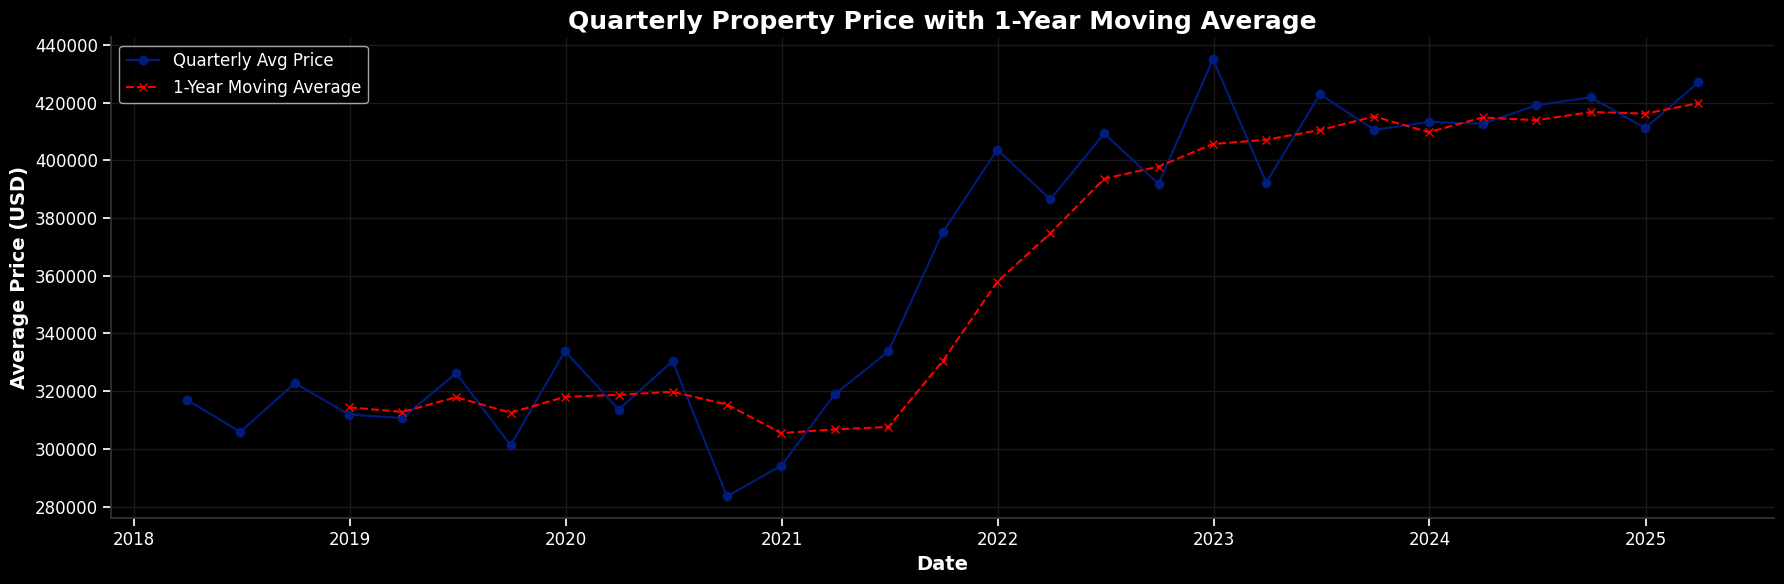

In [68]:
rolling_avg = quarterly_prices.rolling(window=4).mean()  # 4 quarters = 1 year

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(quarterly_prices.index, quarterly_prices.values, marker='o', label='Quarterly Avg Price')
ax.plot(rolling_avg.index, rolling_avg.values, marker='x', linestyle='--', label='1-Year Moving Average', color='red')

custom_theme(ax, title='Quarterly Property Price with 1-Year Moving Average', xlabel='Date', ylabel='Average Price (USD)')
ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

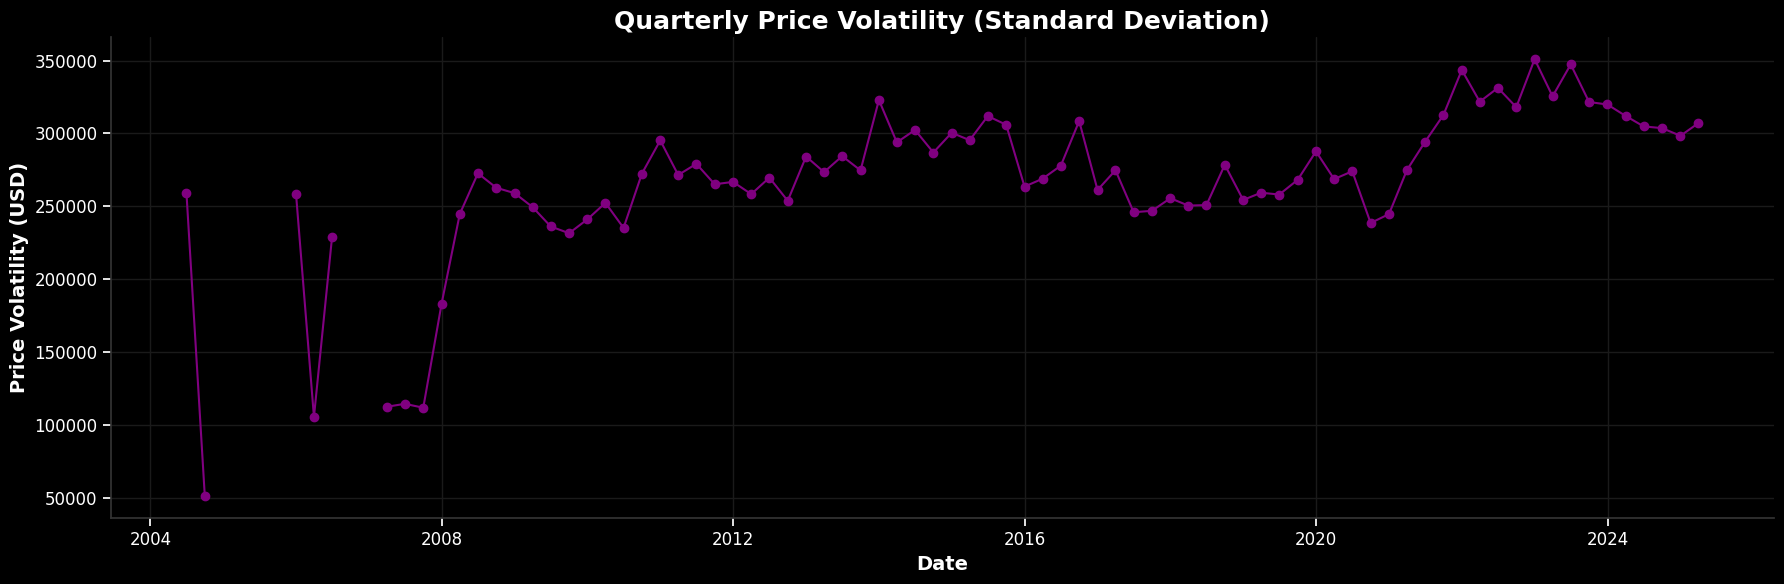

In [69]:
quarterly_std = df.set_index('instance_date').resample('Q')['actual_worth_usd'].std()

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(quarterly_std.index, quarterly_std.values, marker='o', color='purple')
custom_theme(ax, title='Quarterly Price Volatility (Standard Deviation)', xlabel='Date', ylabel='Price Volatility (USD)')
ax.grid(True)
plt.tight_layout()
plt.show()

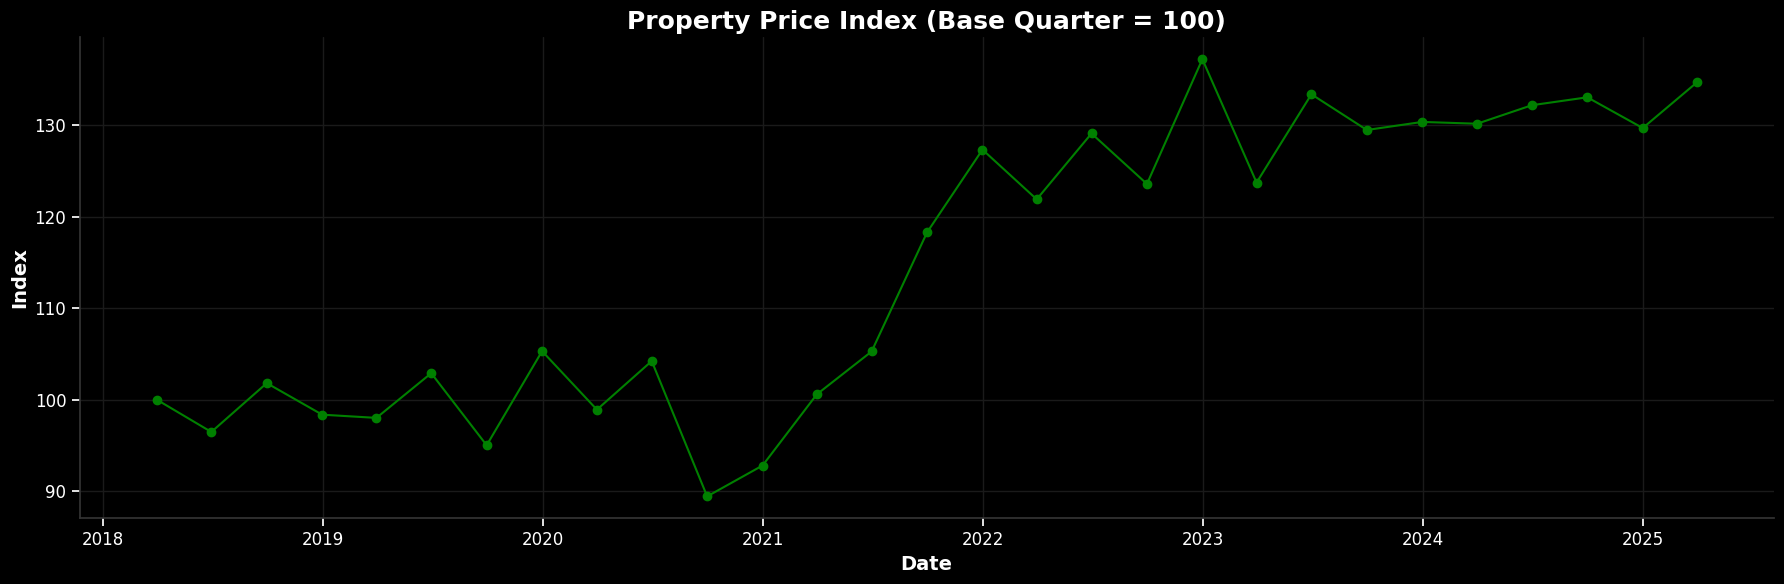

In [70]:
price_index = (quarterly_prices / quarterly_prices.iloc[0]) * 100

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(price_index.index, price_index.values, marker='o', color='green')
custom_theme(ax, title='Property Price Index (Base Quarter = 100)', xlabel='Date', ylabel='Index')
ax.grid(True)
plt.tight_layout()
plt.show()

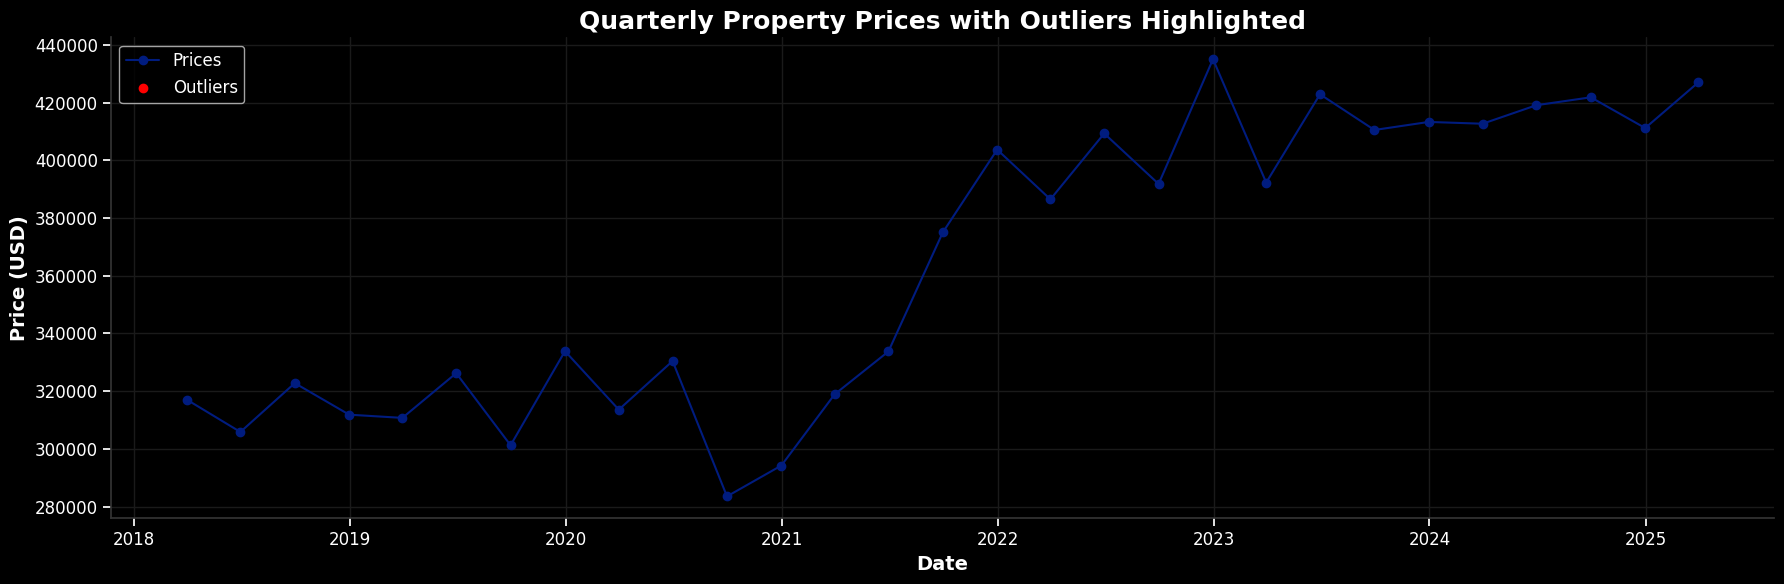

In [71]:
mean = quarterly_prices.mean()
std = quarterly_prices.std()
outliers = quarterly_prices[(quarterly_prices > mean + 2*std) | (quarterly_prices < mean - 2*std)]

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(quarterly_prices.index, quarterly_prices.values, marker='o', label='Prices')
ax.scatter(outliers.index, outliers.values, color='red', label='Outliers', zorder=5)
custom_theme(ax, title='Quarterly Property Prices with Outliers Highlighted', xlabel='Date', ylabel='Price (USD)')
ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

### 3. Seasonality Analysis

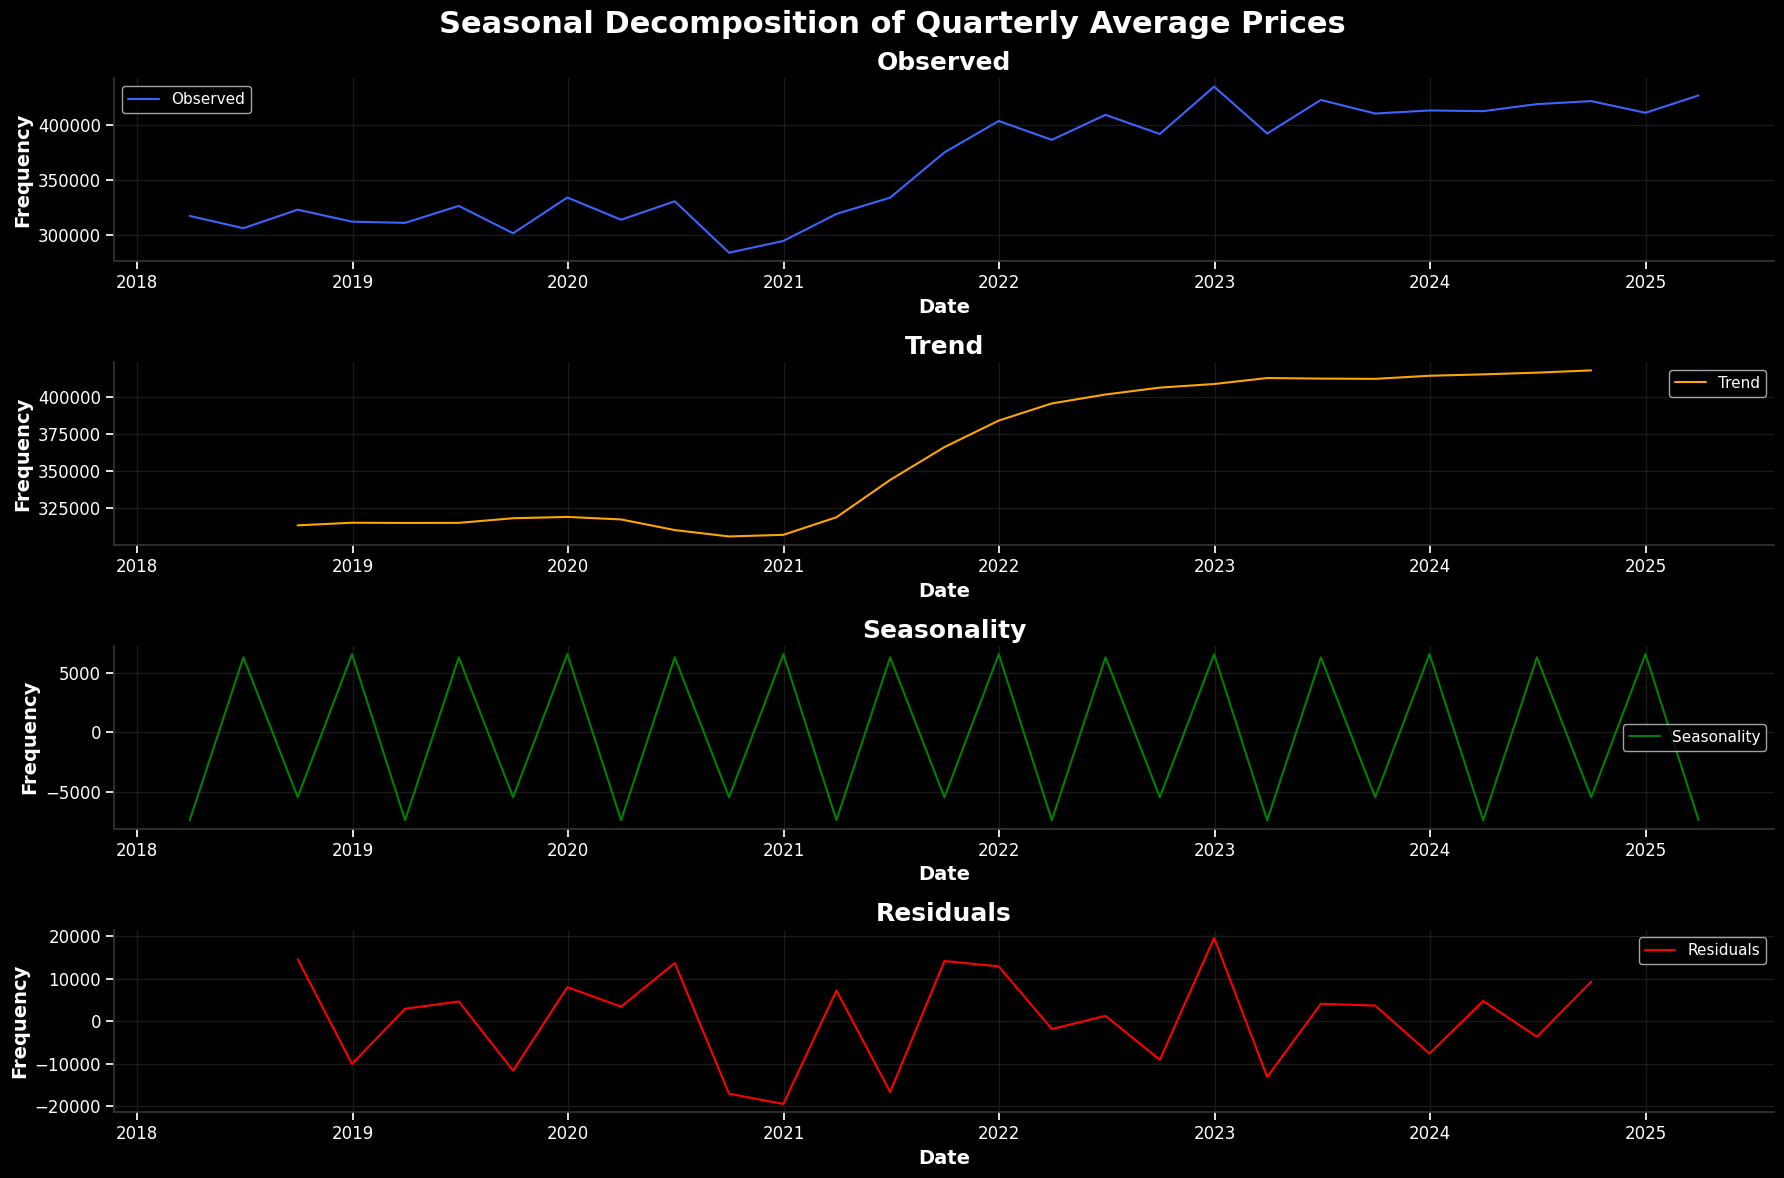

Trend Strength: 0.946
Seasonality Strength: 0.262


In [72]:
# --- Prepare data ---
quarterly_prices = quarterly_prices.dropna()

# --- Seasonal Decomposition ---
decomposition = seasonal_decompose(quarterly_prices, model='additive', period=4)

# --- Plot Decomposition ---
fig, axs = plt.subplots(4, 1, figsize=(18, 12), sharex=True)

titles = ['Observed', 'Trend', 'Seasonality', 'Residuals']
colors = ['#3E64FF', 'orange', 'green', 'red']
components = [decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid]

for ax, title, color, component in zip(axs, titles, colors, components):
    ax.plot(component, label=title, color=color)
    ax.legend()
    custom_theme(ax, title=title, xlabel='Date')

plt.suptitle('Seasonal Decomposition of Quarterly Average Prices', fontsize=22, fontweight='bold')
plt.tight_layout()
plt.show()

# --- Strength Calculations ---
# Remove NaNs from trend, seasonal, and resid components
resid = decomposition.resid.dropna()
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()

# Residual variance
resid_var = np.var(resid)

# Trend strength
trend_var = np.var(trend)
trend_strength = 1 - (resid_var / (resid_var + trend_var))

# Seasonality strength
seasonal_var = np.var(seasonal)
seasonality_strength = 1 - (resid_var / (resid_var + seasonal_var))

# --- Print Results ---
print(f"Trend Strength: {trend_strength:.3f}")
print(f"Seasonality Strength: {seasonality_strength:.3f}")

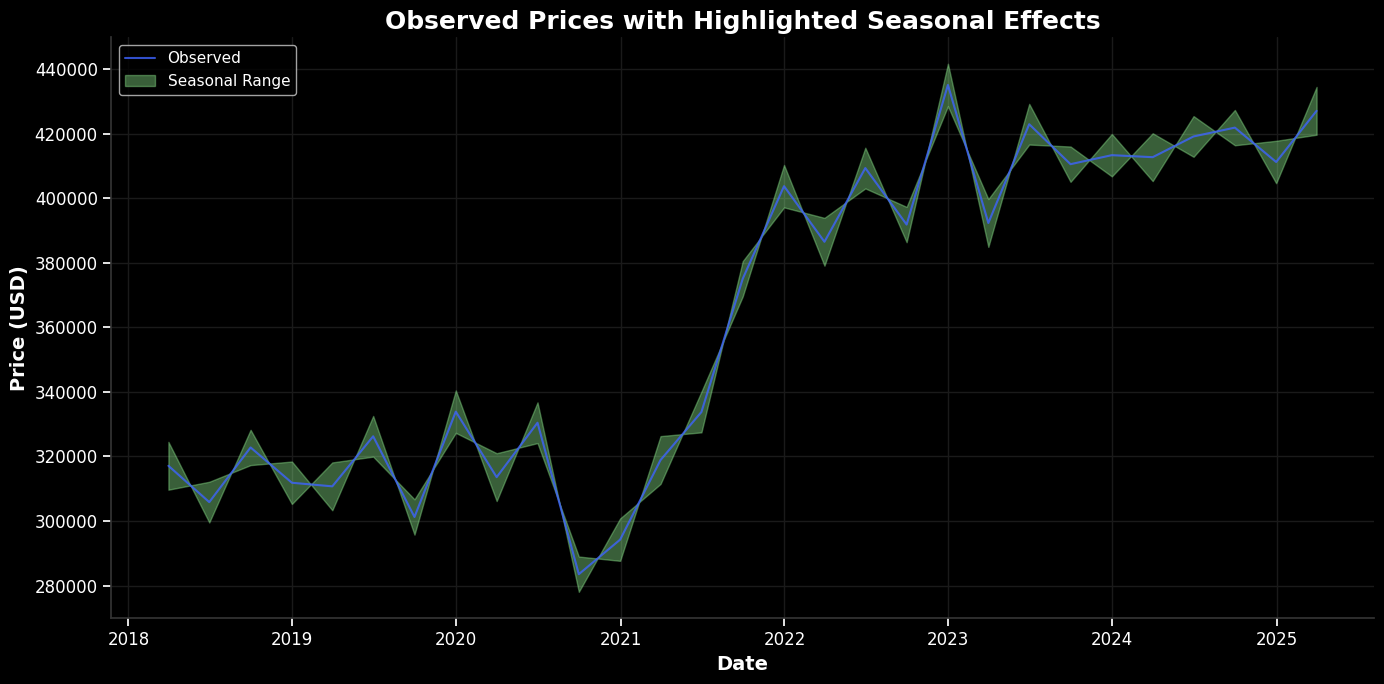

In [73]:
quarterly_prices = quarterly_prices.dropna()

# Seasonal decomposition (specify period=4 for quarterly data)
decomposition = seasonal_decompose(quarterly_prices, model='additive', period=4)

# Retrieve components
observed = decomposition.observed
seasonal = decomposition.seasonal

# Plot observed + seasonal highlight
fig, ax = plt.subplots(figsize=(14, 7))

# Plot observed
ax.plot(observed.index, observed.values, label='Observed', color='#3E64FF', alpha=0.8)

# Overlay seasonal part (as a shaded area)
ax.fill_between(seasonal.index, 
                observed.values - seasonal.values, 
                observed.values + seasonal.values, 
                color='lightgreen', alpha=0.4, label='Seasonal Range')

# Apply your custom theme properly
custom_theme(ax, 
             title='Observed Prices with Highlighted Seasonal Effects', 
             xlabel='Date', 
             ylabel='Price (USD)')

# Legend
ax.legend()

plt.tight_layout()
plt.show()